# 데이터 시각화


Python에서 데이터를 시각화하는 패키지는 매우 많습니다만, 그 중에서 오늘은 기본으로 내장된 시각화 함수인 `plot()`의 사용법,

그리고 최근 현업에서 많이 채택되는 `plotly` 의 사용법 두 가지를 알아보겠습니다.

그 외 `matplotlib`이나 `seaborn` 등은 이미 배우신 분들도 많고, 자료가 웹에 충분히 많아서 오늘은 언급하지 않습니다.

## 시각화 1: 기본 함수를 이용한 시각화
데이터가 어떻게 생겼는지 확인하는, 탐색적 분석과 같이 가단한 시각화는 파이썬 내장 시각화 함수로 해결이 가능합니다.

실습을 위해 주가 데이터를 불러오겠습니다.

주가 데이터를 가져오기 위한 패키지 중에 pykrx라는 패키지가 있습니다.

이 함수를 이용하여 국내 종목의 주가를 가져와 봅시다.

pykrx의 사용법은 [공식 문서](https://github.com/sharebook-kr/pykrx)에 상세히 언급되어 있으므로, 여기서는 구경만 하고 넘어가겠습니다.

In [ ]:
!pip install pykrx

In [27]:
from pykrx import stock

In [28]:
fnf = stock.get_market_ohlcv("20230101", "20230831", "383220") #제가 선택한 종목은 383220 즉 F&F입니다. 1월 1일부터 8월 31일까지의 데이터를 가져옵니다.
fnf.head()

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2023-01-02,146000,146500,136500,140000,222736,-3.114187
2023-01-03,137000,139500,134500,139000,141026,-0.714286
2023-01-04,139000,139500,134500,136000,149283,-2.158273
2023-01-05,136000,137500,132500,135500,160200,-0.367647
2023-01-06,133500,134500,120500,126000,897629,-7.011070


기본 내장 함수로 시각화할 때는 단순히 원하는 데이터 뒤에 `plot()`만 붙이면 시각화가 손 쉽게 가능합니다.

<AxesSubplot:xlabel='날짜'>

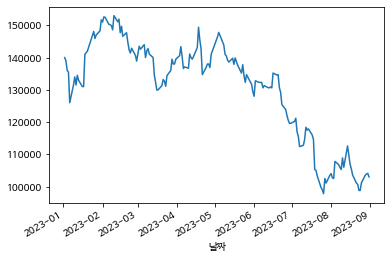

In [69]:
fnf['종가'].plot()

더 많은 시각화를 위해 수익률을 계산하겠습니다.

In [71]:
fnf['전일종가']=fnf['종가'].shift(1)
fnf['수익률(%)']=100*(fnf['종가']-fnf['전일종가'])/fnf['전일종가']
fnf['수익률(%)']

날짜
2023-01-02         NaN
2023-01-03   -0.714286
2023-01-04   -2.158273
2023-01-05   -0.367647
2023-01-06   -7.011070
                ...   
2023-08-25    2.429150
2023-08-28    2.272727
2023-08-29    0.386473
2023-08-30    0.192493
2023-08-31   -1.056676
Name: 수익률(%), Length: 166, dtype: float64

수익률 분포를 확인하기 위해 히스토그램을 그려 봅시다. `kind='hist'` 옵션으로 히스토그램을 그릴 수 있습니다.

kind옵션은 지정하지 않으면 선 그래프를 기본값으로 합니다.

<AxesSubplot:ylabel='Frequency'>

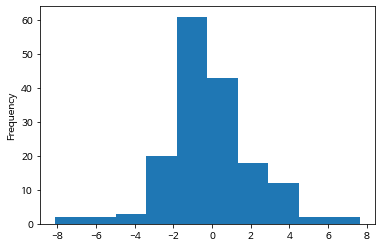

In [73]:
fnf['수익률(%)'].plot(kind='hist')

이번에는 종가와 함께 이동평균선을 그려 봅시다.

세 개의 그래프가 동시에 그려져야 하므로 사이즈도 키우고, 색상도 좀 구분이 쉽게 해야겠네요.

* 시각화할 데이터는 pandas 때 다룬 열 인덱싱 방법과 동일하게 [ ]으로 묶기
* plot 함수 안에 `style` 인자로 그래프의 모양 설정: `ko-`는 검은색+둥근 점+실선, `m--`는 분홍색 점선, `g--`는 초록색 점선, `c-`는 하늘색 점선 을 의미합니다.
* 마찬가지로 `figsize` 인자로 그래프의 크기 설정

In [33]:
#rolling(n).mean()으로 n개 row의 이동평균을 만들 수 있습니다.
fnf['5일선']=fnf['종가'].rolling(5).mean()
fnf['20일선']=fnf['종가'].rolling(20).mean()
fnf['60일선']=fnf['종가'].rolling(60).mean()

<AxesSubplot:xlabel='날짜'>

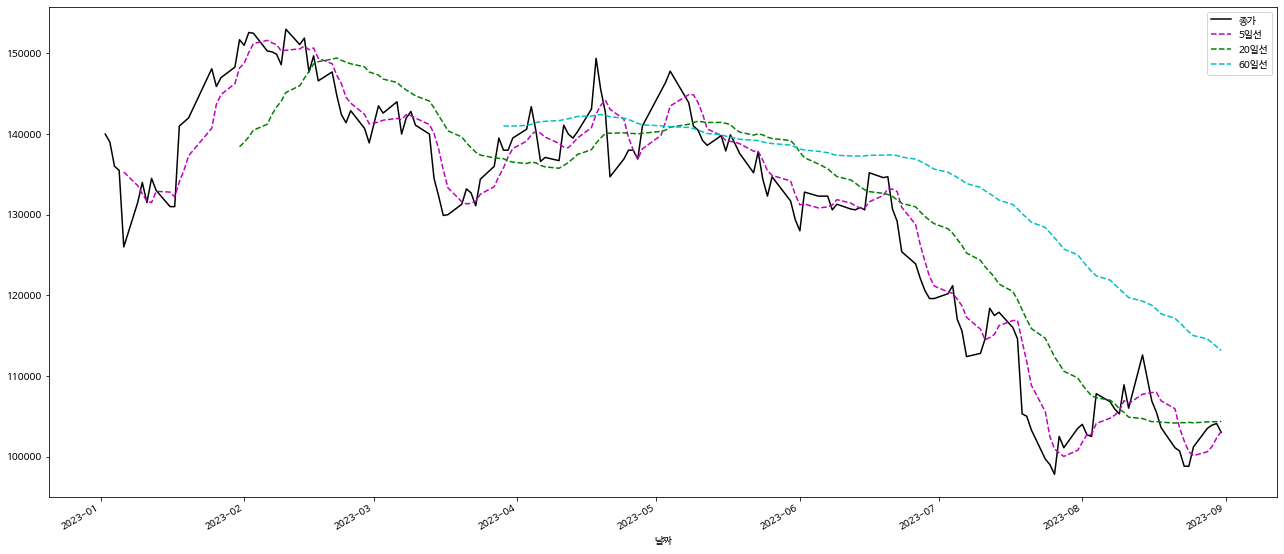

In [42]:
fnf[['종가','5일선','20일선', '60일선']].plot(style=['k-', 'm--', 'g--', 'c--'], figsize=(22,10))

## 실습 2-1. Plotly로 캔들스틱 시각화하기
이번에는 plotly 라는 패키지를 이용해 시각화를 진행해 보겠습니다.

plotly의 최대 장점은 시각화 결과가 이미지가 아니라, 실제 클릭과 이동 등이 가능한 개체로 반환된다는 것입니다.

3차원 그래프나 확대/축소가 필요한 그래프 등이 있을 때 매우 강력한 힘을 발휘하기 때문에, 현업에서 매우 선호받는 시각화 패키지 중 하나입니다.

.

먼저 plotly를 설치해 봅시다.

In [ ]:
!pip install plotly

plotly 안에는 여러가지 시각화 모듈들이 있습니다. 그 중 우리는 plotly안에 있는 graph_objs라는 모듈을 사용합니다.

In [ ]:
import plotly.graph_objs as go

이제 시각화를 해 볼 텐데, 미리 당부의 말씀을 먼저 드리자면,

아래 실습들과 같이 복잡한 시각화는, 시각화를 전문으로 하는 사람이 아니고서야 [예제 코드](https://plotly.com/python/candlestick-charts/)를 먼저 복붙하고 그 코드를 변환해서 쓰는 경우가 많습니다.

따라서 이번 내용도 내용을 완전히 이해하기보다는 시각화를 어떤 과정으로 수행하는지 구경하는 정도로만 가볍게 봐 주세요.

plotly의 시각화의 기본 원리는 다음과 같습니다:

 `go.Figure()` 안에 `data`와 `layout` 두 개의 값을 집어넣으면 시각화가 됩니다.
 - 이때 `data`는 시각화할 데이터를 의미하며,
 - `layout`은 그래프의 부가적인 장식 요소들을 의미합니다.

 `data`에서 원하는 시각화의 유형에 맞게 데이터를 세팅하여 집어 넣으면 그에 맞게 자동으로 시각화가 이루어집니다.

먼저 캔들스틱을 만들기 위해서는 시가, 고가, 저가, 종가로 묶여 있는 data를 만들어야 합니다.

plotly에서 제공하는 `go.Candlestick`함수를 통해, 가격 데이터를 plotly가 이해할 수 있는 캔들스틱 형태로 바꿔 줍시다.

In [88]:
candle = go.Candlestick(
	x=fnf.index, #x축은 dataframe의 인덱스 즉 날짜
	open=fnf['시가'], #open인자에는 시가를
	high=fnf['고가'], #high인자에는 고가를
	low=fnf['저가'], #low인자에는 저가를
	close=fnf['종가'], #close인자에는 종가를 넣고
    increasing_line_color='red', #양봉은 빨간색으로
    decreasing_line_color='blue') #음봉은 파란색으로

candle

Candlestick({
    'close': array([140000, 139000, 136000, 135500, 126000, 131500, 134000, 131500, 134500,
                    133000, 131000, 131000, 141000, 141500, 142000, 148100, 145900, 147000,
                    148300, 151700, 151000, 152600, 152500, 150300, 150200, 149900, 148600,
                    153000, 151100, 151900, 147700, 149700, 146600, 147700, 144800, 142400,
                    141400, 142900, 140700, 138900, 143500, 142600, 144000, 140000, 142000,
                    142800, 141100, 140000, 134500, 132300, 129900, 130000, 131300, 133200,
                    132700, 131100, 134400, 136000, 139500, 138000, 138000, 139500, 140600,
                    143400, 140400, 136600, 137100, 136700, 141100, 140000, 139500, 140300,
                    143100, 149400, 145500, 142700, 134700, 136900, 138000, 138000, 136900,
                    141000, 145300, 146400, 147800, 143900, 141000, 140500, 139200, 138600,
                    139800, 137900, 139900, 138800, 137600, 135200

다음으로 layout을 만들어 봅시다.

In [89]:
style=go.Layout(title='F&F (383220)', #제목 지정
                yaxis_title='종가') #y축 이름 지정

style

Layout({
    'title': {'text': 'F&F (383220)'}, 'yaxis': {'title': {'text': '종가'}}
})

이제 data, layout에 들어갈 두 개의 데이터를 만들었습니다. 이 두개를 넣으면 시각화가 뿅!

In [84]:
fig = go.Figure(data=candle, layout=style)
fig.show()
#아래쪽의 바를 조정하여 확대/축소/이동을 직접 수행해 보세요.

## 실습 2-2. Plotly로 그릭스 시각화하기
조금 전 파생부에서 그릭스가 무엇인지 보았습니다.
그렇다면 실제 유러피안 옵션에서 그릭스가 어떤 형태로 나타나는지 살펴보겠습니다.

시간 관계상 수업에서는 델타의 형태만 확인해 보겠습니다.

**마찬가지로 시각화는 그 과정만 가볍게 구경해 주시고, 실제 Delta Surface가 어떻게 나오는지 그 결과에만 집중해 주셔도 충분합니다.**

참고로 해당 교안은 [여기](https://blog.naver.com/PostView.naver?blogId=quantdaddy&logNo=221598012745&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView) 나오는 코드를 간략화한 내용입니다.

나머지 그릭스에 대해서도 궁금하신 분은 해당 소스를 참고해 주세요.

In [5]:
import numpy as np
import scipy.stats as stat
import plotly.graph_objs as go

들어가기 전에 **사용자 정의 함수**를 간단히 설명하겠습니다.

앞서 살펴본 lambda보다 복잡하고 긴 연산을 만들 때는 def문을 사용해 사용자가 원하는 연산을 수행하는 함수를 만듭니다.

```
def 함수이름(인자1, 인자2, ...)
    인자들을 활용한 연산
    return 반환받을 값
```

In [45]:
def simple_function(x, y):
    logx=np.log(x)
    logy=np.log(y)
    return logx+logy

In [ ]:
simple_function(1, np.e) #값이 얼마가 나올까요?

이제 옵션의 델타값을 반환하는 함수를 만들어 봅시다.

BSM에서 델타는 결국 기초자산 가격 변화에 대한 옵션의 민감도를 의미하므로, 옵션 가격을 기초자산의 가격으로 편미분하여 계산할 수 있습니다.

해당 과정은 시간 관계상 생략하고, 그렇게 델타의 공식을 구하면

![.](https://moneymorning.com/wp-content/blogs.dir/1/files/2020/01/image-1.png)

이 됩니다.

이때 $N(d_1)$은 $d_1$의 누적정규분포 값을 의미하므로, $d_1$을 구한 후 그 누적정규분포값을 구해 델타를 알 수 있습니다.

In [46]:
#옵션의 델타를 반환하는 함수를 생성
def delta(option_type, S, K, r, T, sigma): #옵션의 종류(콜/풋), 행사가, 무위험이자율, 만기, 시그마 값을 입력받습니다
    
    d1=(np.log(S/K)+(r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T)) #d1을 구하는 공식 구현

    if option_type=='call': #option_type자리에 'call'이 들어갈 경우, 즉 콜옵션일 경우
        return stat.norm.cdf(d1) #d1의 누적분포값을 반환하면 되고,

    else: #그 외의 값이 들어갈 경우 ('put'을 넣을 예정입니다)
        return stat.norm.cdf(d1)-1 #풋옵션은 거기서 1을 빼면 됩니다.


옵션의 `행사가`, `무위험이자율`, `기초자산의 시그마`가 정해져 있다고 가정하고,

`만기까지의 시간` 및 `기초자산 가격`의 변화에 따라 `델타`가 어떻게 변하는지 확인해 보겠습니다.

In [47]:
K=100 #행사가격=100달러
r=0.01 #무위험이자율: 1%
sigma=0.25 #주가의 변동성: 25%

#만기 값들을 만들어 줍니다.
T=np.linspace(0.000001, 1, 100) #첫 시간에 배운 linspace로, 0부터 1까지 100개의 수를 만들어줍니다.
#이때 첫 값이 0이 아닌 이유는, d1을 계산할 때 분모에 만기가 들어가기 때문입니다.

#기초자산 가격 값들을 만들어줍니다.
S=np.linspace(0.000001, 200, 200) #마찬가지로 0에서 200까지 200개의 수를 만들어줍니다.

T, S = np.meshgrid(T,S) #두 1차원 행렬 T, S를 조합하여 2차원 행렬을 만들어줍니다.

이제 이 값들을 사용자 정의 함수에 넣어 델타값을 만들겠습니다.

In [48]:
call_delta=delta(option_type='call',S=S, K=K, r=r, T=T, sigma=sigma)
put_delta=delta(option_type='put', S=S, K=K, r=r, T=T, sigma=sigma)

In [50]:
call_delta.shape #만기 값 100개 × 기초자산 값 200개 조합에 대한 델타값이 계산되어 있습니다.

(200, 100)

이제 시각화를 위해 data, layout에 해당하는 값을 만들어 줍시다.

surface라고 하는 그래프를 그리기 위해 `go.Surface`라는 기능으로 그 형태에 맞는 데이터를 만들어 주겠습니다.

In [64]:
surface=[go.Surface(x=T, #x축 값 = 만기
                    y=S, #y축 값 = 기초자산 가격
                    z=call_delta, #z축 값= 콜옵션 델타값
                    colorscale='geyser', #색상 테마
                    opacity=0.9)] #불투명도

style=go.Layout(title='콜옵션 델타 Surface', #그래프 이름
                 scene={'xaxis':{'title': 'X: 만기'}, #x축 이름
                        'yaxis':{'title': 'Y: 기초자산가격(ATM=100)'}, #y축 이름
                        'zaxis':{'title': 'Z: 델타'}}, #z축 이름
                width=1000, #너비
                height=1000) #폭

In [65]:
fig=go.Figure(data=surface, layout=style)
fig.show()

1. 기초자산가격(X)이 커질수록 델타값(Z)이 커지는 것을 볼 수 있습니다.

   `기초자산가격 > 옵션 행사가`인 경우, 즉 내가격 상태가 될수록 옵션이 행사될 가능성이 높아지므로 델타는 1에 가까워지겠죠.

2. (yz평면과 그 반대쪽에서 봅시다)만기(Y)가 1에 가까울 때는 델타가 완만한 S자 그래프를 띄는 반면, 만기에 다가가면 ATM을 기준으로 델타가 급격히 계단식으로 변하는 모습을 볼 수 있습니다.

   옵션이 만기에 가까워질수록 내가격 상태가 될 지, 외가격 상태가 될 지가 확실해지므로 델타값이 0과 1이라는 극단값으로만 표현됨을 의미합니다.

참고로 풋옵션의 경우에는 아래와 같이 델타 surface가 표현됩니다.

In [63]:
surface=[go.Surface(x=T, #x축 값 = 만기
                    y=S, #y축 값 = 기초자산 가격
                    z=put_delta, #z축 값= 풋옵션 델타값
                    colorscale='geyser', #색상 테마
                    opacity=0.9)] #불투명도

style=go.Layout(title='풋옵션 델타 Surface', #그래프 이름
                 scene={'xaxis':{'title': 'X: 만기'}, #x축 이름
                        'yaxis':{'title': 'Y: 기초자산가격(ATM=100)'}, #y축 이름
                        'zaxis':{'title': 'Z: 델타'}}, #z축 이름
                width=1000, #너비
                height=1000) #폭

fig=go.Figure(data=surface, layout=style)
fig.show()